Trial 15 Complete [00h 04m 56s]
val_rmse: 0.41863614320755005

Best val_rmse So Far: 0.41291841864585876
Total elapsed time: 01h 19m 18s
Epoch 1/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 0.7163 - rmse: 0.6419 - val_loss: 0.3366 - val_rmse: 0.4791
Epoch 2/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 0.2388 - rmse: 0.4603 - val_loss: 0.2834 - val_rmse: 0.4336
Epoch 3/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 0.2233 - rmse: 0.4508 - val_loss: 0.2902 - val_rmse: 0.4487
Epoch 4/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 0.2192 - rmse: 0.4475 - val_loss: 0.3725 - val_rmse: 0.5238
Epoch 5/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 0.2174 - rmse: 0.4455 - val_loss: 0.3073 - val_rmse: 0.4631
Epoch 6/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.2154 - rmse: 0.4431 - val_loss: 0.3212 - val_rmse: 0.4640
Epoch 7/50
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.2142 - rmse: 0.4419 - val_loss: 0.2594 - val_rmse: 0.

Best Model Test Loss: 0.4191, Test RMSE: 0.5248


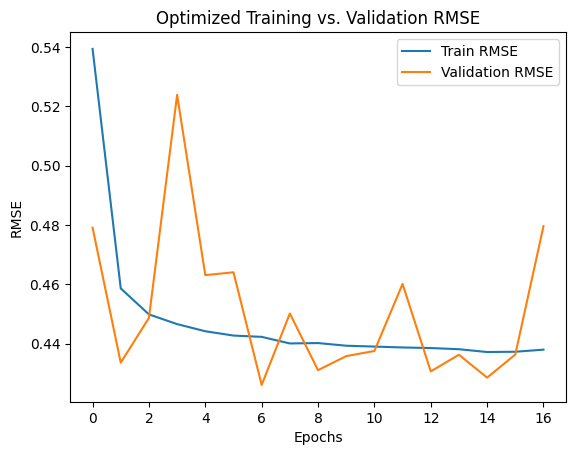

In [5]:
import keras_tuner as kt
from keras.models import Model
from keras import layers, optimizers, regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
import json

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
lookback = 10  

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)


# Define Model for Hyperparameter Tuning
def build_model(hp):
    x_shape = (lookback, len(x_cols))  # Define input shape
    
    regs = {
        'kernel_regularizer': regularizers.l2(hp.Float('reg_rate', 1e-6, 1e-3, sampling='log')),
        'bias_regularizer': regularizers.l2(hp.Float('reg_rate', 1e-6, 1e-3, sampling='log')),
        'activity_regularizer': regularizers.l2(hp.Float('reg_rate', 1e-6, 1e-3, sampling='log'))
    }

    def add_common_layers(z):
        z = layers.BatchNormalization()(z)
        activation_choice = hp.Choice('activation', ['relu', 'tanh', 'selu'])
        z = layers.Activation(activation_choice)(z)  # Apply activation properly
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
        z = layers.Dropout(dropout_rate)(z)  # Apply dropout properly
        return z


    x = layers.Input(shape=x_shape)
    y = x  

    for i in range(hp.Int('n_layers', 2, 5)):  # Search for best number of layers (2 to 5)
        dilation_rate = hp.Int('dilation_start_rate', 1, 4) * (2 ** i)

        if i % 2 == 0 and hp.Boolean('residual'):
            shortcut = y  

        y = layers.Conv1D(
            hp.Int('n_units', 32, 128, step=32), 
            hp.Int('kernel_size', 2, 5),  
            padding='causal',
            dilation_rate=dilation_rate,
            activation=None,  
            **regs
        )(y)
        y = add_common_layers(y)

        if i % 2 == 1 and hp.Boolean('residual'):
            shortcut = layers.Conv1D(hp.Int('n_units', 32, 128, step=32), kernel_size=1, padding='causal', activation=None, **regs)(shortcut)
            y = layers.add([shortcut, y])

    y = layers.GlobalMaxPooling1D()(y)
    y = layers.Dense(len(y_cols))(y)  

    model = Model(inputs=x, outputs=y)

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr_rate = hp.Float('lr_rate', 1e-5, 1e-2, sampling='log')

    opt = optimizers.Adam(learning_rate=lr_rate) if optimizer == 'adam' else (
          optimizers.RMSprop(learning_rate=lr_rate) if optimizer == 'rmsprop' else 
          optimizers.SGD(learning_rate=lr_rate))

    model.compile(optimizer=opt, loss='mse', metrics=[rmse])
    return model

# Define Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=15,  # Number of different hyperparameter sets to try
    executions_per_trial=1,  # Number of times to train each model configuration
    directory='tcn_tuner_results',
    project_name='cnn_tcn_optimization'
)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_rmse', patience=5, mode='min')])

# Get Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train Best Model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_rmse', patience=10, mode='min')])

# Evaluate on Test Set
test_loss, test_rmse = best_model.evaluate(X_test, y_test)
print(f'Best Model Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}')

# Save Model
best_model.save('optimized_cnn_tcn_model.h5')

# Save Best Hyperparameters
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open("best_hyperparameters.json", "w") as f:
    json.dump(best_hps_dict, f, indent=4)

# Plot RMSE over Epochs
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Optimized Training vs. Validation RMSE')
plt.show()
